### Библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Функции предобработки

In [2]:
def reduction_memory(df: pd.DataFrame) -> pd.DataFrame:
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[df_c[column].notna()][column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    mb_before = df.memory_usage().sum() * 1e-6
    mb_after = df_c.memory_usage().sum() * 1e-6
    mb_reduced = mb_before - mb_after
    
    print(f'before:\t\t{round(mb_before, 2)} mb\n', 
          f'after:\t\t{round(mb_after, 2)} mb\n',
          f'reduсed:\t{round(mb_reduced, 2)} mb',
          sep='')
    
    return df_c

### Чтение датасета и уменьшение объема

In [3]:
PATH_TO_FILE = 'freMPL-R.csv'

df = pd.read_csv(PATH_TO_FILE, parse_dates=['RecordBeg', 'RecordEnd'])
df = df.drop_duplicates()
df = reduction_memory(df)

df.head()

before:		62.22 mb
after:		44.72 mb
reduсed:	17.5 mb


,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,ClaimInd,Dataset,DeducType,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.583,366,2004-06-01,NaT,2,Female,Other,CSP1,Professional,55,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.200,187,2004-10-19,NaT,0,Male,Alone,CSP55,Private+trip to office,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.375,170,2004-08-16,NaT,1,Female,Other,CSP1,Professional,34,...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## На основе датасета из ноутбука проведите анализ данных и постройте зависимости частоты и среднего убытка от какого-либо параметра (за исключением уже выполненных в ноутбуке).

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243065 entries, 0 to 343079
Data columns (total 31 columns):
Exposure             243065 non-null float64
LicAge               243065 non-null int16
RecordBeg            243065 non-null datetime64[ns]
RecordEnd            126584 non-null datetime64[ns]
VehAge               127875 non-null object
Gender               243065 non-null object
MariStat             243065 non-null object
SocioCateg           243065 non-null object
VehUsage             243065 non-null object
DrivAge              243065 non-null int8
HasKmLimit           243065 non-null int8
BonusMalus           243065 non-null int16
VehBody              105776 non-null object
VehPrice             105776 non-null object
VehEngine            105776 non-null object
VehEnergy            105776 non-null object
VehMaxSpeed          105776 non-null object
VehClass             105776 non-null object
ClaimAmount          243065 non-null float64
RiskVar              105776 non-null floa

##### Клиенты зарегистрированные в какие месяци получали больший объем исков по страховке среди фактов запросов на иск

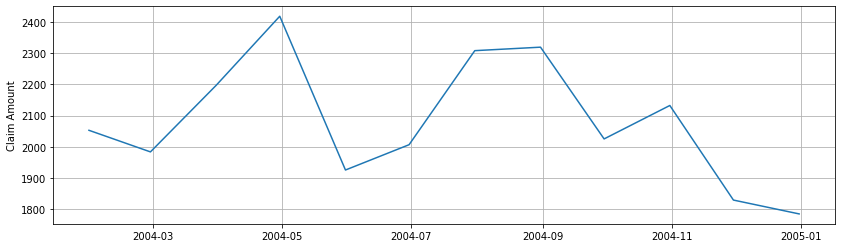

In [5]:
# Record beg x Claim amount
RecB_ClaimA = df[df['ClaimInd'] == 1][['RecordBeg', 'ClaimAmount']]
RecB_ClaimA = RecB_ClaimA.set_index('RecordBeg').sort_index()
RecB_ClaimA = RecB_ClaimA.resample('M').mean()

plt.figure(figsize=(14,4))

plt.plot(RecB_ClaimA.index, RecB_ClaimA['ClaimAmount'])
plt.ylabel('Claim Amount')
plt.grid()

plt.show()

- Видно что клюенты составившие договора в мае, а так же с августа по сентябрь получали больший объем компенсации

_являются ли эти показатели цикличными или они не зависят от сезона?_

##### Теперь просмотрим в какие месяци больше всего запросов на возмещение страховки

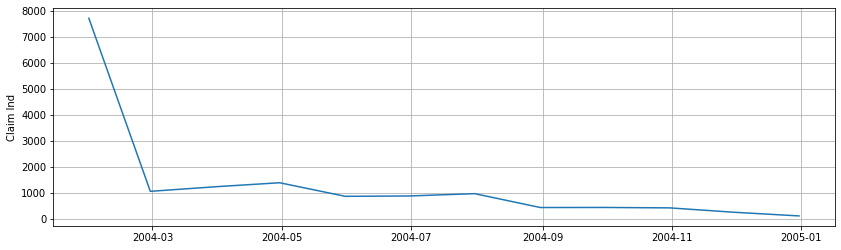

In [6]:
RecB_ClaimI = df[['RecordBeg', 'ClaimInd']].set_index('RecordBeg')
RecB_ClaimI = RecB_ClaimI.sort_index()
RecB_ClaimI = RecB_ClaimI.resample('M').sum()

plt.figure(figsize=(14,4))

plt.plot(RecB_ClaimI.index, RecB_ClaimI['ClaimInd'])
plt.ylabel('Claim Ind')

plt.grid()
plt.show()

- больше всего запросов в январе

##### Просмотрим в какких каэффициентах - Бонус Малус самые больший средний показатель исков на страховку

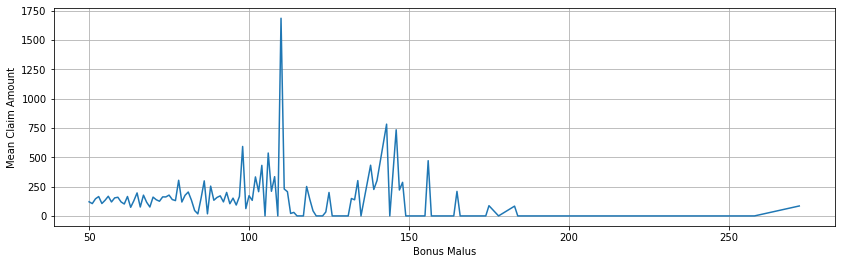

In [7]:
BonusM = df[['BonusMalus', 'ClaimAmount', 'ClaimInd']]

BonusMalus = []
ClaimAmount = []
ClaimInd = []

for bm in BonusM['BonusMalus'].unique():
    mean_ca = BonusM[BonusM['BonusMalus'] == bm]['ClaimAmount'].mean()
    count_ci = BonusM[BonusM['BonusMalus'] == bm]['ClaimInd'].sum()
    
    BonusMalus.append(bm)
    ClaimAmount.append(mean_ca)
    ClaimInd.append(count_ci)
    
Bm_dict = {'BonusMalus':BonusMalus, 'ClaimAmount': ClaimAmount, 'ClaimInd':ClaimInd}

Bm = pd.DataFrame(Bm_dict).set_index('BonusMalus')
Bm = Bm.sort_index()

# plot
plt.figure(figsize=(14,4))
plt.plot(Bm.index, Bm['ClaimAmount'])

plt.xlabel('Bonus Malus')
plt.ylabel('Mean Claim Amount')

plt.grid()
plt.show()

- Самые высокие запраты по искам находятсяв промежутке от 100 - 150

##### Теперь просмотрим - лиди с каким показателем Бонус Малус запрашивают иски чаще

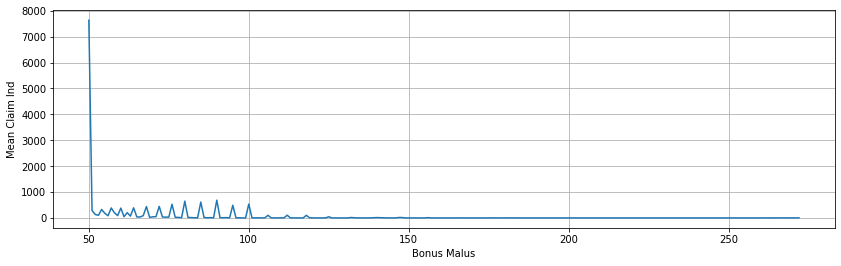

In [8]:
# plot
plt.figure(figsize=(14,4))
plt.plot(Bm.index, Bm['ClaimInd'])

plt.xlabel('Bonus Malus')
plt.ylabel('Mean Claim Ind')

plt.grid()
plt.show()

- Видно что люди с самым низким коеффициентом Бонул Малус запрашивают иски чаше
 
Видно, что люди с рейтингом от 100 до 150 полючают __большее возмещение__ по страховке, при том, что количество исков у них меньше. В то же время люди с __низкий рейтингом__, запрашивающие иски чаще получают гораздо __меньше компенсации__.<br>
- _Говорит ли это о недобосовестности вторых или есть другие причины?_